## Model architecture

Our goal is to perform segmentation first to extract cells from an image. And then perform analysis based on the data we generate.

#### Step 1
The first task is a binary classification problem. But the data we have is not tagged. So first we will build a model on an existing dataset. The Dataset used here is taken from [https://bbbc.broadinstitute.org/BBBC005/]. Then train a model to get a baseline model which performs cell segmentation. Here the base model we are building is a U-net model.

#### Step 2
The second step is to use the Train and Validation dataset we have and use the model we build to predict on the these images. This will give us a probable ground dataset.

#### Step 3
Use the ground dataset we generated in the previous step along with annotation tools to generate a good ground dataset. The performance of the model to be build depends a lot on how accurately the train and validation data is tagged. It should be as close to the original value as possible. 

The images could be tagged ont heir own without going through the previous steps. But these steps makes it easy for it to be tagged. This will allow the person tagging to focus on correcting the ground dataset. 

#### Step 4
Use this dataset now to train the model which is already trained in step 1. This will help fine tune the model and build a better model.

#### Step 5 
Once the cells are recognised from the image. Getting the count, area, centroid etc is a matter of simple image processing using opencv.


The image could be rgb (3D, 3 channels) or black and white (2D, 1 channel). It's essentially a matrix with values that range between 0 and 255.

<hr>

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1

NUM_TEST_IMAGES = 10


> **Data**<br>

> We are given 19,200 images. Of those 1200 have associated masks. We will only use those 1200 images in this kernel. The images and their masks have the same file name but they are stored in separate folders.

## Put Info Into a Dataframe

This dataframe will show the following info:
- id's of all images
- does the image have a mask?
- number of cells on each image
- the blur amount that was aded to each image

In [9]:
# get a list of files in each folder

img_list = os.listdir('BBBC005_v1_images')
mask_list = os.listdir('BBBC005_v1_ground_truth/BBBC005_v1_ground_truth')

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])

# filter out the non image file that's called .htaccess
df_images = df_images[df_images['image_id'] != '.htaccess']



# Example file name: SIMCEPImages_A13_C53_F1_s23_w2.TIF


# ======================================================
# Add a column showing how many cells are on each image
# ======================================================

def get_num_cells(x):
    # split on the _
    a = x.split('_')
    # choose the third item
    b = a[2] # e.g. C53
    # choose second item onwards and convert to int
    num_cells = int(b[1:])
    
    return num_cells

# create a new column called 'num_cells'
df_images['num_cells'] = df_images['image_id'].apply(get_num_cells)


# ================================================
# Add a column indicating if an image has a mask.
# ================================================

# Keep in mind images and masks have the same file names.

def check_for_mask(x):
    if x in mask_list:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'has_mask'
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)



# ===========================================================
# Add a column showing how much blur was added to each image
# ===========================================================

def get_blur_amt(x):
    # split on the _
    a = x.split('_')
    # choose the third item
    b = a[3] # e.g. F1
    # choose second item onwards and convert to int
    blur_amt = int(b[1:])
    
    return blur_amt

# create a new column called 'blur_amt'
df_images['blur_amt'] = df_images['image_id'].apply(get_blur_amt)

In [11]:
df_images.head(10)

,image_id,num_cells,has_mask,blur_amt
0,SIMCEPImages_K12_C48_F32_s19_w1.TIF,48,no,32
1,SIMCEPImages_H22_C91_F23_s18_w2.TIF,91,no,23
2,SIMCEPImages_D02_C5_F10_s03_w1.TIF,5,no,10
3,SIMCEPImages_I06_C23_F26_s08_w1.TIF,23,no,26
4,SIMCEPImages_K05_C18_F32_s24_w1.TIF,18,no,32
5,SIMCEPImages_J24_C100_F29_s08_w1.TIF,100,no,29
6,SIMCEPImages_I16_C66_F26_s24_w1.TIF,66,no,26
7,SIMCEPImages_J04_C14_F29_s07_w1.TIF,14,no,29
8,SIMCEPImages_O20_C83_F45_s10_w2.TIF,83,no,45
9,SIMCEPImages_G16_C66_F20_s04_w1.TIF,66,no,20


## Create a dataframe containing only images that have masks

We will only use this dataframe in the rest of this notebook.

In [12]:
df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = df_masks['image_id']

df_masks.shape

(1200, 5)

In [13]:
df_masks.head()

,image_id,num_cells,has_mask,blur_amt,mask_id
27,SIMCEPImages_A19_C78_F1_s04_w2.TIF,78,yes,1,SIMCEPImages_A19_C78_F1_s04_w2.TIF
28,SIMCEPImages_A21_C87_F1_s20_w2.TIF,87,yes,1,SIMCEPImages_A21_C87_F1_s20_w2.TIF
80,SIMCEPImages_A06_C23_F1_s07_w1.TIF,23,yes,1,SIMCEPImages_A06_C23_F1_s07_w1.TIF
87,SIMCEPImages_A21_C87_F1_s11_w1.TIF,87,yes,1,SIMCEPImages_A21_C87_F1_s11_w1.TIF
99,SIMCEPImages_A16_C66_F1_s18_w1.TIF,66,yes,1,SIMCEPImages_A16_C66_F1_s18_w1.TIF


## Create a Test Set

Here we will create a test set containing 10 images. Keras will automatically create a validation set during training.

In [14]:
# create a test set
df_test = df_masks.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
# This is so that we can use loc to access mask id's later.
df_test = df_test.reset_index(drop=True)

# create a list of test images
test_images_list = list(df_test['image_id'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_masks = df_masks[~df_masks['image_id'].isin(test_images_list)]

print(df_masks.shape)
print(df_test.shape)

(1190, 5)
(10, 5)


In [15]:
# ==================================================== #

## Inspect one Image and Mask

Here we want to find out:

- What are the shapes?
- Is the image rgb or black and white?

We need this info to write the code that will process the images and masks into a format that the model requires.

## Image

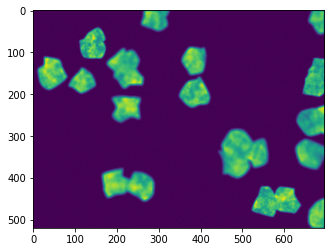

In [16]:
sample_image = 'SIMCEPImages_A06_C23_F1_s11_w2.TIF'
path_image = 'BBBC005_v1_images/' + sample_image

# read the image using skimage
image = imread(path_image)

plt.imshow(image)

In [17]:
print('Shape: ', image.shape)
print('Max pixel value: ', image.max())
print('Min pixel value: ', image.min())

Shape:  (520, 696)
Max pixel value:  222
Min pixel value:  0


## Mask

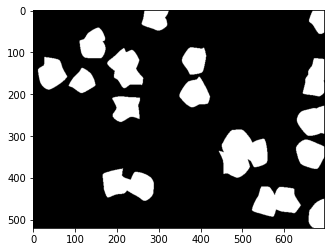

In [18]:
sample_mask = 'SIMCEPImages_A06_C23_F1_s11_w2.TIF'
path_mask = 'BBBC005_v1_ground_truth/BBBC005_v1_ground_truth/' + sample_mask

# read the mask using skimage
mask = imread(path_mask)

plt.imshow(mask, cmap='gray')

In [19]:
print('Shape: ', mask.shape)
print('Max pixel value: ', mask.max())
print('Min pixel value: ', mask.min())

Shape:  (520, 696)
Max pixel value:  255
Min pixel value:  0


The image and its associated mask have the same shape. We see that the image is 2D and not 3D. The mask is 2D. The image has pixel values in the range 0 to 255. The mask has pixel values that are either 0 or 255. 0 is black and 255 is white.

The model requires this input format:<br>

*(num_samples, num_rows, num_columns, num_channels)*

Therefore, we will need to use np.expand_dims to add a channel dimension to both the image and the mask.

Also, the model expects input images and masks to have the same width and height. We will therefore resize both images and the masks to 128 x 128.

## Create X_train, Y_train and X_test

This processing code is the most important part of this kernel. If you see crazy results during training, like negative loss values - then you've most probably made an error on this step. 

In [20]:
# Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
test_id_list = list(df_test['image_id'])

# Create empty arrays

X_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

Y_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

X_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)



In [22]:
# X_train


for i, image_id in enumerate(image_id_list):
    
    path_image = 'BBBC005_v1_images/' + image_id
    
    # read the image using skimage
    image = imread(path_image)
    
    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(image, axis=-1)
    
    # insert the image into X_train
    X_train[i] = image
    
X_train.shape

(1190, 128, 128, 1)

In [23]:
# Y_train


for i, mask_id in enumerate(mask_id_list):
    
    path_mask = 'BBBC005_v1_ground_truth/BBBC005_v1_ground_truth/' + mask_id
    
    # read the image using skimage
    mask = imread(path_mask)
    
    # resize the image
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)
    
    # insert the image into Y_Train
    Y_train[i] = mask

Y_train.shape

(1190, 128, 128, 1)

In [24]:
# X_test

for i, image_id in enumerate(test_id_list):
    
    path_image = 'BBBC005_v1_images/' + image_id
    
    # read the image using skimage
    image = imread(path_image)
    
    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(image, axis=-1)
    
    # insert the image into X_test
    X_test[i] = image
    
X_test.shape

(10, 128, 128, 1)

## Define the Model Architecture

We will use the U-Net arhitecture. U-Net is a cnn that was developed for biomedical image segmentation. It was designed to give good results when only a small number of training images are available. It was also designed to run fast.

Paper: [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)<br>
Olaf Ronneberger, Philipp Fischer, Thomas Brox

Take note that the images are normalized inside the model using a lamda layer.

In [26]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [27]:
# source: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277


inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

2022-09-14 19:02:35.626099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

 conv2d_15 (Conv2D)             (None, 64, 64, 32)   9248        ['dropout_7[0][0]']              
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 128, 128, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 128, 128, 32  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 16  4624        ['concatenate_3[0][0]']          
                                )                                                                 
          

## Train the Model

We will let Keras automatically create a 10% validation set during training. I haven't specified a metric, but for segmentation problems I've often seen custom metrics like IOU or dice coef be used.

In [28]:
filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=callbacks_list)

Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 0.0924
Epoch 1: val_loss improved from inf to 0.03795, saving model to model.h5
67/67 [==============================] - 118s 2s/step - loss: 0.0924 - val_loss: 0.0379
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 0.0366
Epoch 2: val_loss improved from 0.03795 to 0.02994, saving model to model.h5
67/67 [==============================] - 136s 2s/step - loss: 0.0366 - val_loss: 0.0299
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 0.0312
Epoch 3: val_loss improved from 0.02994 to 0.02710, saving model to model.h5
67/67 [==============================] - 99s 1s/step - loss: 0.0312 - val_loss: 0.0271
Epoch 4/50
67/67 [==============================] - ETA: 0s - loss: 0.0281
Epoch 4: val_loss improved from 0.02710 to 0.02402, saving model to model.h5
67/67 [==============================] - 95s 1s/step - loss: 0.0281 - val_loss: 0.0240
Epoch 5/50
67/67 [============================

## Make a Prediction

In [29]:
# Make a prediction

# use the best epoch
model.load_weights('model.h5')

test_preds = model.predict(X_test)

1/1 [==============================] - 0s 274ms/step


In [30]:
# Threshold the predictions

preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)

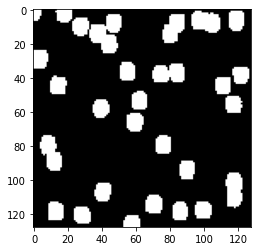

In [31]:
# Display a thresholded mask

test_img = preds_test_thresh[5, :, :, 0]

plt.imshow(test_img, cmap='gray')

## Inspect the Results

Here we will display 3 test images, their true masks and the masks that the model predicted for those images.

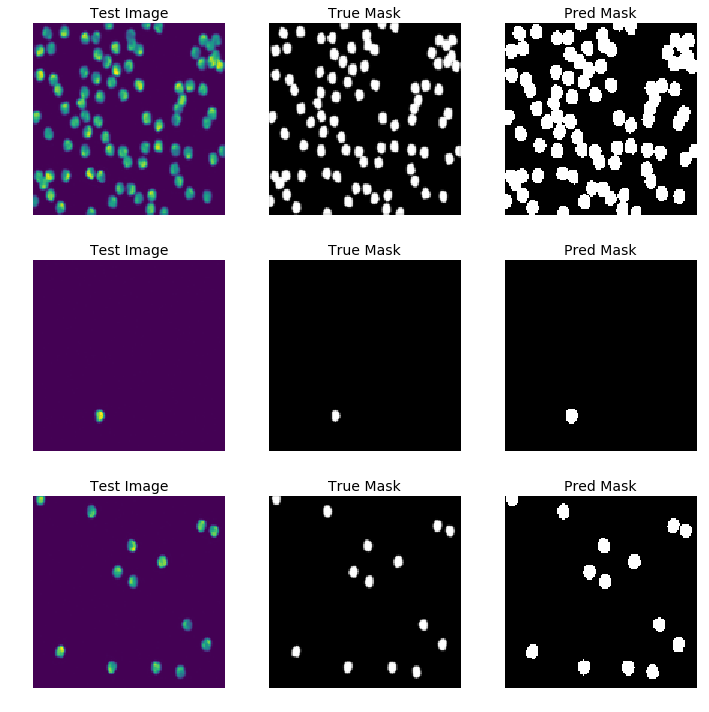

In [23]:
# set up the canvas for the subplots
plt.figure(figsize=(10,10))
plt.axis('Off')

# Our subplot will contain 3 rows and 3 columns
# plt.subplot(nrows, ncols, plot_number)


# == row 1 ==

# image
plt.subplot(3,3,1)
test_image = X_test[1, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
# plt.subplot(3,3,2)
# mask_id = df_test.loc[1,'mask_id']
# path_mask = '../input/bbbc005_v1_ground_truth/BBBC005_v1_ground_truth/' + mask_id
# mask = imread(path_mask)
# mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
# plt.imshow(mask, cmap='gray')
# plt.title('True Mask', fontsize=14)
# plt.axis('off')

# predicted mask
plt.subplot(3,3,3)
test_mask = preds_test_thresh[1, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')


# == row 2 ==

# image
plt.subplot(3,3,4)
test_image = X_test[2, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,5)
mask_id = df_test.loc[2,'mask_id']
path_mask = '../input/bbbc005_v1_ground_truth/BBBC005_v1_ground_truth/' + mask_id
mask = imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,6)
test_mask = preds_test_thresh[2, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')

# == row 3 ==

# image
plt.subplot(3,3,7)
test_image = X_test[3, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,8)
mask_id = df_test.loc[3,'mask_id']
path_mask = '../input/bbbc005_v1_ground_truth/BBBC005_v1_ground_truth/' + mask_id
mask = imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,9)
test_mask = preds_test_thresh[3, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')


plt.tight_layout()
plt.show()

This notebook is based on this excellent kernel by Kjetil Åmdal-Sævik: [Keras U-Net starter - LB 0.277](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277)<br> Many thanks to Kjetil for demystifying the segmentation deep learning workflow.